<a href="https://colab.research.google.com/github/mahdavipanah/IoT-Colab/blob/main/IoT_Colab_alpha_beta_(Changing_16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to the paper https://www.sciencedirect.com/science/article/pii/S0959652621016267

Link to the slides: https://docs.google.com/presentation/d/1dhO9MWNpegfj3nEEvdvgV3j-j4GoPN5AMzw2mZ3EoIc/edit#slide=id.gf31ab12f31_0_283

Link to the paper's file: https://drive.google.com/file/d/1CokHcR_pmj7ArbuVO3c5RwixoAO8j-q0/view

In [5]:
pip install dataframe-image

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import dataframe_image as dfi
import imageio
from pathlib import Path
import os


%load_ext google.colab.data_table

from google.colab import data_table
data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.4f}"

plt.figure(figsize=(20, 5))

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [15]:
#@title #Parameters

#@markdown Prior knowledge for the probability of the event occurrence:
PE = 0.7#@param {type:"number"}

#@markdown Selection ratio in the list of nodes:
S = 1000#@param {type:"integer"}
K = 100#@param {type:"integer"}

#@markdown Number of malicious nodes:
MALICIOUS_NODES_COUNT = 300#@param {type:"integer"}

#@markdown Number of revoked nodes:
REVOKED_NODES_COUNT = 0#@param {type:"integer"}
#@markdown Probability of a revoked node to report a malicious probability:
P_REVOKE_MALICIOUS = 0.7#@param {type:"number"}

#@markdown Number of repaired nodes:
REPAIRED_NODES_COUNT = 0#@param {type:"integer"}

if (REPAIRED_NODES_COUNT > MALICIOUS_NODES_COUNT):
  raise Exception('Number of rapaired nodes can not be more than malicious count')

#@markdown The iteration to start the repairing node process:
REPAIR_ITERATION = 40#@param {type:"integer"}

#@markdown Trusted nodes probability range (inclusive):
P_START = 0.5#@param {type:"number"}
P_END = 0.99#@param {type:"number"}

#@markdown Malicious nodes probability range (inclusive):
MALICIOUS_P_START = 0.01#@param {type:"number"}
MALICIOUS_P_END = 0.49#@param {type:"number"}

#@markdown Punishment and reward for trust of nodes based on Nash EQ:
TRUST_PUNISH = 0.05#@param {type:"number"}
TRUST_REWARD = 0.03#@param {type:"number"}

#@markdown Maximum and minimum trust:
TRUST_MAX = 0.9#@param {type:"number"}
TRUST_MIN = 0.1#@param {type:"number"}

#@markdown Default Trust:
TRUST_DEFAULT = 0.5#@param {type:"number"}

#@markdown Number of iterations:
ITERATIONS_COUNT = 100#@param {type:"integer"}

#@markdown Indicates weather the code must generate plot image files or not:
GENERATE_PLOT_PNG = False#@param {type:"boolean"}

#@markdown Folder for saving plog pngs (old png files will be removed):
PLOT_PNG_FOLDER = "/content/drive/MyDrive/n-t-plot/pngs"#@param {type:"string"}

#@markdown Plot's variable:
PLOT_VARIABLE = "trust" #@param ["trust"]

#@markdown Trust upper and lower bound for plots:
UPPER_BOUND = 0.75#@param {type:"number"}
LOWER_BOUND = 0.3#@param {type:"number"}

#@markdown Default duration for sensors:
DURATION_SENSOR_DEFAULT = 0#@param {type:"integer"}

#@markdown Malicious nodes power range:
POWER_MALICIOUS_START = 0.3#@param {type:"number"}
POWER_MALICIOUS_END = 0.6#@param {type:"number"}

#@markdown Non-malicious (trusted and revoked_ nodes power range:
POWER_NON_MALICIOUS_START = 0.7#@param {type:"number"}
POWER_NON_MALICIOUS_END = 0.98#@param {type:"number"}

#@markdown Heartbeat functionality:
HEARTBEAT_NODES_COUNT = 0#@param {type:"integer"}
HEARTBEAT_START_ITERATION = 60#@param {type:"integer"}
HEARTBEAT_END_ITERATION = 80#@param {type:"integer"}


In [8]:
from google.colab import drive

if GENERATE_PLOT_PNG:
  drive.mount('/content/drive')

In [9]:
plt.figure(figsize=(20, 5))

rng = np.random.default_rng()

def run(mal_count, repair_nodes_config, revoked_nodes_count, heartbeat_options=None, with_alpha_beta=True):
  MALICIOUS_NODES_COUNT = mal_count
  REVOKED_NODES_COUNT = revoked_nodes_count

  if heartbeat_options == None:
    heartbeat_options = {
      'count': 0,
      'start': 0,
      'end': 0
    }

  # indices of all nodes
  nodes_indices = np.arange(S)
  # indices of malicious nodes
  malicious_indices = rng.choice(
      nodes_indices,
      size=MALICIOUS_NODES_COUNT,
      replace=False
  )

  # indices of repair nodes
  all_repair_indices = np.array([])

  # indices of revoked nodes
  revoked_indices = rng.choice(
      np.delete(nodes_indices, malicious_indices),
      size=REVOKED_NODES_COUNT,
      replace=False
  )
  # indices of trusted nodes
  trusted_indices = np.delete(
      nodes_indices,
      np.concatenate([malicious_indices, revoked_indices])
  )

  # indices of heartbeat nodes
  heartbeat_indices = rng.choice(
      trusted_indices,
      size=heartbeat_options['count'],
      replace=False
  )

  # indices of non-modified trust nodes to show in plot
  trusted_plot_indices = np.delete(
      nodes_indices,
      np.concatenate([malicious_indices, revoked_indices, heartbeat_indices])
  )

  total_averages = np.array([])

  data_frame = pd.DataFrame()

  if GENERATE_PLOT_PNG:
    # remove old pngs plots
    [f.unlink() for f in Path(PLOT_PNG_FOLDER).glob("*.png") if f.is_file()]

  plot_list = np.array([])

  for iter in np.arange(ITERATIONS_COUNT):
    # start the repair process
    for conf in repair_nodes_config:
      if iter == conf[1]:
        # indices of repair nodes
        repair_indices = rng.choice(
            malicious_indices,
            size=conf[0],
            replace=False
        )
        malicious_indices = malicious_indices[
          ~np.isin(malicious_indices, repair_indices)
        ]
        trusted_indices = np.concatenate([trusted_indices, repair_indices])
        all_repair_indices = np.concatenate([all_repair_indices, repair_indices])

    # trusted nodes probabilities
    trusted_nodes = rng.uniform(
      P_START,
      P_END,
      len(trusted_indices),
    )
    # malicious nodes probabilities
    malicious_nodes = rng.uniform(
      MALICIOUS_P_START,
      MALICIOUS_P_END,
      len(malicious_indices),
    )
    # revoked nodes probabilities
    revoked_nodes = np.array([])
    for i in np.arange(len(revoked_indices)):
      p_start = p_end = None
      if rng.random() <= P_REVOKE_MALICIOUS:
        p_start, p_end = MALICIOUS_P_START, MALICIOUS_P_END
      else:
        p_start, p_end = P_START, P_END
      
      revoked_nodes = np.append(revoked_nodes,rng.uniform(p_start, p_end))
    
    # malicious nodes powers
    malicious_powers = rng.uniform(
      POWER_MALICIOUS_START,
      POWER_MALICIOUS_END,
      len(malicious_indices),
    )

    # non-malicious (trusted and revoked) nodes powers
    non_malicious_powers = rng.uniform(
      POWER_NON_MALICIOUS_START,
      POWER_NON_MALICIOUS_END,
      len(trusted_indices) + len(revoked_indices),
    )

    nodes = np.array([])
    powers = np.array([])
    for i in np.arange(S):
      elem = None
      power = None

      if np.any(np.isin(malicious_indices, i)):
        elem, malicious_nodes = malicious_nodes[0], np.delete(malicious_nodes, 0)

        power, malicious_powers = malicious_powers[0], np.delete(malicious_powers, 0)
      elif np.any(np.isin(revoked_indices, i)):
        elem, revoked_nodes = revoked_nodes[0], np.delete(revoked_nodes, 0)

        power, non_malicious_powers = non_malicious_powers[0], np.delete(non_malicious_powers, 0)
      else:
        elem, trusted_nodes = trusted_nodes[0], np.delete(trusted_nodes, 0)

        power, non_malicious_powers = non_malicious_powers[0], np.delete(non_malicious_powers, 0)

      nodes = np.append(nodes, elem)
      powers = np.append(powers, power)

    data_frame['probability'] = nodes
    data_frame['power'] = powers

    if iter == 0:
      data_frame['trust'] = TRUST_DEFAULT
      data_frame['duration'] = DURATION_SENSOR_DEFAULT

    # generate plot image files
    if GENERATE_PLOT_PNG or iter == ITERATIONS_COUNT - 1:
      plt.clf()
      plt.scatter(
          trusted_plot_indices,
          data_frame.loc[trusted_plot_indices, PLOT_VARIABLE].values,
          color="green",
          label='Trusted nodes',
      )
      plt.scatter(
          heartbeat_indices,
          data_frame.loc[heartbeat_indices, PLOT_VARIABLE].values,
          color='pink',
          label='Heartbeat nodes',
      )
      if iter >= REPAIR_ITERATION:
        plt.scatter(
            all_repair_indices,
            data_frame.loc[all_repair_indices, PLOT_VARIABLE].values,
            color="blue",
            label= 'Repaired nodes',
        )
      plt.scatter(
          malicious_indices,
          data_frame.loc[malicious_indices, PLOT_VARIABLE].values,
          color="red",
          label= 'Malicious nodes',
      )
      plt.scatter(
          revoked_indices,
          data_frame.loc[revoked_indices, PLOT_VARIABLE].values,
          color="orange",
          label= 'Revoked nodes',
      )
      plt.ylim(0, 1)
      plt.xlim(0, S - 1)
      plt.xlabel('Node ID', fontsize=18)
      plt.ylabel("Node's " + PLOT_VARIABLE, fontsize=18)
      plt.axhline(UPPER_BOUND, color="green", label="Upper bound")
      plt.axhline(LOWER_BOUND, color="orange", label="Lower bound")
      plt.grid()
      plt.title(f'Round {iter + 1}')
      plt.suptitle(f'PE: {PE} - Rounds: {ITERATIONS_COUNT} - Repair config: {repair_nodes_config} - Trusted count: {len(trusted_indices)} - Malicious count: {MALICIOUS_NODES_COUNT} - Revoked count: {REVOKED_NODES_COUNT} - Heartbeat nodes count: {heartbeat_options["count"]} - Heartbeat start round: {heartbeat_options["start"]} - Heartbeat end round: {heartbeat_options["end"]}')
      if GENERATE_PLOT_PNG:
        png_filename = os.path.join(PLOT_PNG_FOLDER, str(iter) + '.png')
        plt.legend()
        plt.savefig(png_filename)
        plot_list = np.append(plot_list, png_filename)

    for n in np.arange(S//K):
      # indecies of the n-th E-Sensor
      sensor_indices = np.arange(n * K, n * K + K)

      if iter >= heartbeat_options['start'] and iter <= heartbeat_options['end']:
        sensor_indices = [i for i in sensor_indices if i not in heartbeat_indices]
      
      for i in sensor_indices:
        i_prob = data_frame.at[i, 'probability']

        # indices of other nodes of the sensor
        others_indices = np.delete(
          sensor_indices,
          np.where(sensor_indices == i)
        )

        # average of other nodes of the sensor
        others_average = np.mean(
            data_frame.loc[others_indices, 'probability'].values
        )
        data_frame.at[i, 'average'] = others_average

        # cost1nodes_indices
        i_cost1 = (i_prob - others_average) ** 2
        data_frame.at[i, 'cost1'] = i_cost1
        
        # cost2 calculations
        consistant_t = 1
        non_consistent_t = 1
        
        beta = 1
        data_frame.at[i, 'duration'] += 1

        for j in others_indices:
          j_prob = data_frame.at[j, 'probability']

          condition = (j_prob - 0.5) * (PE - 0.5)
          
          if condition < 0:
            consistant_t *= j_prob
          else:
            non_consistent_t *= j_prob

          beta *= (data_frame.at[j, 'duration'] / (iter + 1)) * data_frame.at[j, 'power'] * data_frame.at[j, 'trust']
        
        pi_et = ((PE * consistant_t) /
                (PE * consistant_t + (1 - PE) * non_consistent_t))

        i_cost2 = (i_prob - pi_et) ** 2
        data_frame.at[i, 'cost2'] = i_cost2

        age = data_frame.at[i, 'duration'] / (iter + 1)
        alpha = age * data_frame.at[i, 'power'] * data_frame.at[i, 'trust']
        if with_alpha_beta:
          data_frame.at[i, 'utility'] = (1 - alpha) * (i_cost1) + (1 - beta) * (i_cost2)
        else:
          data_frame.at[i, 'utility'] = i_cost1 + i_cost2

      # this need to change to mean and std    mean+ std > u > mean - std 
      std = data_frame['utility'].std()
      mn = data_frame['utility'].mean() 

      # return sensor_indices to the state that contains heartbeat nodes
      sensor_indices = np.arange(n * K, n * K + K)

      th_tail = mn - std
      th_head = mn + std

      for i in sensor_indices:
        i_prob = data_frame.at[i, 'probability']
        i_trust = data_frame.at[i, 'trust']

        i_new_trust = None

        if i in heartbeat_indices and iter >= heartbeat_options['start'] and iter <= heartbeat_options['end']:
          i_new_trust = i_trust - TRUST_PUNISH
          if i_new_trust < TRUST_MIN:
            i_new_trust = TRUST_MIN
        else:
          condition_base = i_prob >= th_tail and i_prob <= th_head 
          if condition_base if PE >= 0.5 else not(condition_base):
            # punish sensor's trust
            if i_trust - TRUST_PUNISH > TRUST_MIN:
              i_new_trust = i_trust - TRUST_PUNISH
            else:
              i_new_trust = TRUST_MIN
          else:
            # reward sensor's trust
            if i_trust + TRUST_REWARD < TRUST_MAX:
              i_new_trust = i_trust + TRUST_REWARD
            else:
              i_new_trust = TRUST_MAX
        
        data_frame.at[i, 'trust'] = i_new_trust
    
    # trust average of the system in each iteration
    total_average = np.average(
        data_frame['trust'].values
    )

    total_averages = np.append(total_averages, total_average)

  return data_frame, total_averages

<Figure size 1440x360 with 0 Axes>

,probability,power,trust,duration,average,cost1,cost2,utility,system trust average
0,0.298860,0.569093,0.10,100,0.634694,0.112784,0.089317,0.193758,0.14002
1,0.393543,0.415250,0.10,100,0.633738,0.057694,0.154876,0.209455,0.14002
2,0.695501,0.708173,0.10,100,0.630688,0.004201,0.483721,0.487594,0.14002
3,0.934068,0.963424,0.14,100,0.628278,0.093507,0.872483,0.956081,0.14002
4,0.357777,0.352649,0.16,100,0.634099,0.076354,0.128004,0.198704,0.14002
...,...,...,...,...,...,...,...,...,...
995,0.598343,0.911397,0.10,100,0.640295,0.001760,0.358014,0.359613,0.14002
996,0.988774,0.779590,0.13,100,0.636351,0.124202,0.977673,1.092192,0.14002
997,0.982795,0.872482,0.13,100,0.636412,0.119981,0.965884,1.075397,0.14002
998,0.969320,0.713445,0.22,100,0.636548,0.110738,0.939581,1.035307,0.14002


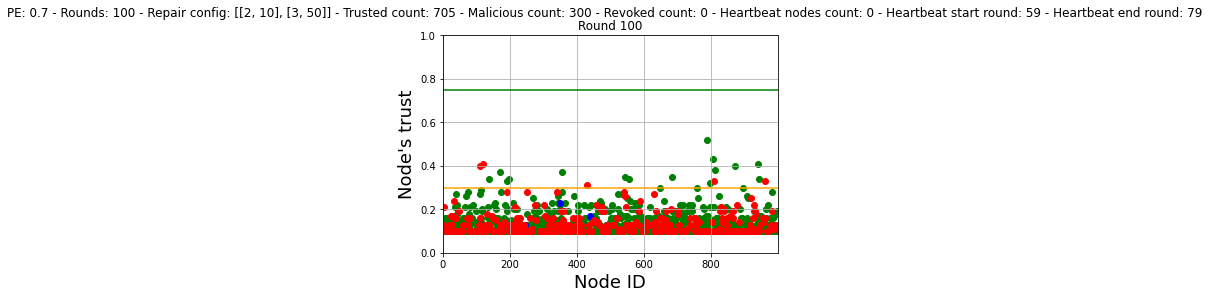

In [16]:
heartbeat_options = {
    "count": HEARTBEAT_NODES_COUNT,
    "start": HEARTBEAT_START_ITERATION - 1,
    "end": HEARTBEAT_END_ITERATION - 1
}
# An array of repair node configs: [[number of repairs, iteration numbber], ...]
REPAIR_NODES_CONFIG = [[2, 10], [3, 50]]
data_frame, total_averages = run(MALICIOUS_NODES_COUNT, REPAIR_NODES_CONFIG, REVOKED_NODES_COUNT, heartbeat_options, with_alpha_beta=True)

data_frame

Mean  0.08794964606650668
std 0.14953789082191907
 The utility should be between-0.061588244755412386and0.23748753688842575


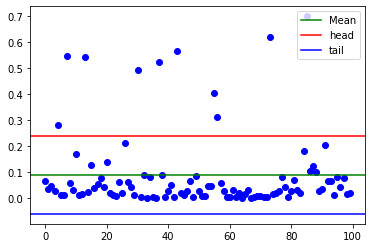

In [ ]:
std = data_frame['utility'].std()
mn = data_frame['utility'].mean() 
plt.scatter(np.arange(0,100,1), data_frame['utility'] .values, marker='o', c = 'b')


plt.axhline(mn, c = 'g', label = 'Mean')
plt.axhline(mn + std, c = 'r', label = 'head')
plt.axhline(mn - std, c = 'b', label= 'tail')


plt.legend()
print('Mean ', mn)
print('std',std)
print( ' The utility should be between' + str(mn - std) + 'and' +str(mn + std))

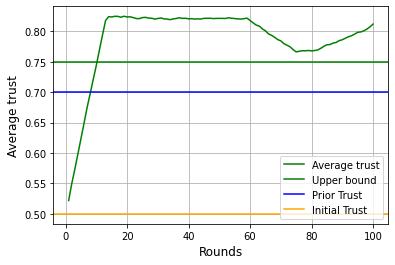

In [ ]:
plt.plot(np.arange(1, ITERATIONS_COUNT + 1), total_averages, label = 'Average trust', c= 'g')

plt.axhline(UPPER_BOUND, color="green", label="Upper bound")
#plt.axhline(LOWER_BOUND, color="Red", label="Lower bound")
plt.axhline(PE, color="Blue", label="Prior Trust")
plt.axhline(0.5, color="Orange", label="Initial Trust ")
plt.xlabel('Rounds', fontsize=12)
plt.ylabel("Average trust", fontsize=12)
#plt.title('  Evaluation of the game theory model ')
#plt.suptitle(f'PE: {PE} - Repair round: {REPAIR_ITERATION} - Trusted count: {len(trusted_indices)} - Malicious count: {MALICIOUS_NODES_COUNT} - Revoked count: {REVOKED_NODES_COUNT} - Repair count: {REPAIRED_NODES_COUNT}')
plt.legend()
plt.grid()

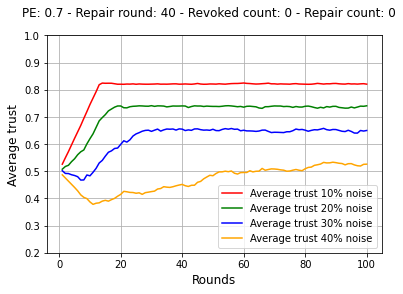

In [ ]:
colors = ['red', 'green', 'blue', 'orange']
mal_counts = [10, 20, 30, 40]
total_averages = []
for i in range(4):
  data_frame, total_average = run(S * mal_counts[i] // 100, [], 0)
  total_averages.append(total_average)

indexes = np.arange(1, ITERATIONS_COUNT + 1);
plt.clf()
for i in range(4):
  plt.plot(indexes, total_averages[i], label = f'Average trust {mal_counts[i]}% noise', c= colors[i])
  # linestyle="dashed"

plt.xlabel('Rounds', fontsize=12)
plt.ylabel("Average trust", fontsize=12)
plt.ylim(0.2, 1)
plt.suptitle(f'PE: {PE} - Repair round: {REPAIR_ITERATION} - Revoked count: {REVOKED_NODES_COUNT} - Repair count: {REPAIRED_NODES_COUNT}')
plt.legend()
plt.grid()

<Figure size 432x288 with 0 Axes>

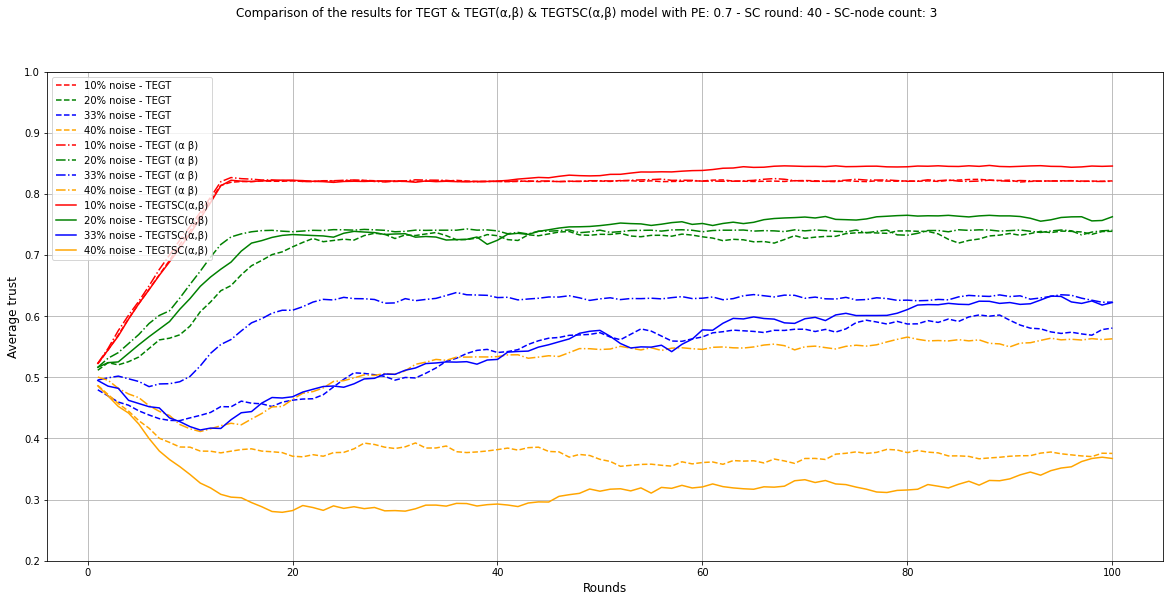

In [ ]:
# plot system's average trust - (TEGT) & (TEGT - α β) & (TEGT - SC - α β)

colors = ['red', 'green', 'blue', 'orange']
mal_counts = [10, 20, 33,40]

total_averages = []
for i in range(4):
  data_frame, total_average = run(S * mal_counts[i] // 100, [], 0)
  total_averages.append(total_average)

total_averages_without_alpha_beta = []
for i in range(4):
  data_frame, total_average = run(S * mal_counts[i] // 100, [], 0, with_alpha_beta=False)
  total_averages_without_alpha_beta.append(total_average)

repair_config = [[3, 20]]
total_averages_second_chance = []
for i in range(4):
  data_frame, total_average = run(S * mal_counts[i] // 100, repair_config, 0, with_alpha_beta=False)
  total_averages_second_chance.append(total_average)

indexes = np.arange(1, ITERATIONS_COUNT + 1);
plt.clf()
plt.figure(figsize=(20, 9))
for i in range(4):
  plt.plot(indexes, total_averages_without_alpha_beta[i], label = f'{mal_counts[i]}% noise - TEGT', c= colors[i], linestyle='dashed')
for i in range(4):
  plt.plot(indexes, total_averages[i], label = f'{mal_counts[i]}% noise - TEGT (α β)', c= colors[i], linestyle='dashdot')
for i in range(4):
  plt.plot(indexes, total_averages_second_chance[i], label = f'{mal_counts[i]}% noise - TEGTSC(α,β)', c= colors[i], linestyle='solid' )

plt.xlabel('Rounds', fontsize=12)
plt.ylabel("Average trust", fontsize=12)
plt.ylim(0.2, 1)
plt.suptitle(f'Comparison of the results for TEGT & TEGT(α,β) & TEGTSC(α,β) model with PE: {PE} - SC config: {repair_config}')
plt.legend()
plt.grid()

In [ ]:
for i in range(4): 
  print('TEGT-Ab', mal_counts[i], np.max(total_averages[i]))
  print('TEGT ', mal_counts[i],np.max(total_averages_without_alpha_beta[i]))
  print('TEGT_SC_AB model  ', mal_counts[i], np.max(total_averages_second_chance[i]))
  
  

TEGT 10 0.8267000000000003
TEGT_AB  10 0.8238000000000002
TEGT_SC_AB model   10 0.8465000000000004
TEGT 20 0.7427000000000004
TEGT_AB  20 0.7394999999999999
TEGT_SC_AB model   20 0.7650000000000002
TEGT 33 0.6386999999999999
TEGT_AB  33 0.6020000000000001
TEGT_SC_AB model   33 0.6329000000000001
TEGT 40 0.5658000000000001
TEGT_AB  40 0.48680000000000023
TEGT_SC_AB model   40 0.4860000000000002


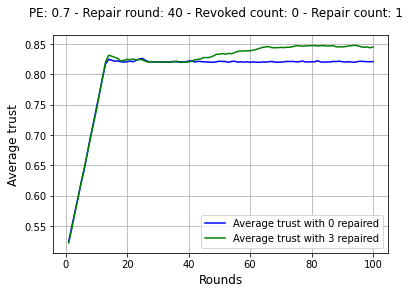

In [ ]:
mal_count = S * 10 // 100
_, total_average_without_repaired = run(mal_count, [], 0)
_, total_average_with_repaired = run(mal_count, [[3, 40]], 0)

indexes = np.arange(1, ITERATIONS_COUNT + 1);
plt.clf()
plt.plot(indexes, total_average_without_repaired, label=f'Average trust with 0 repaired', c='blue')
plt.plot(indexes, total_average_with_repaired, label=f'Average trust with 3 repaired', c='green')

plt.xlabel('Rounds', fontsize=12)
plt.ylabel("Average trust", fontsize=12)
plt.suptitle(f'Evaluating trust value with the second chance protocol Repair round: {REPAIR_ITERATION} - Revoked count: {REVOKED_NODES_COUNT} - Repair count: {REPAIRED_NODES_COUNT}')
plt.legend()
plt.grid()

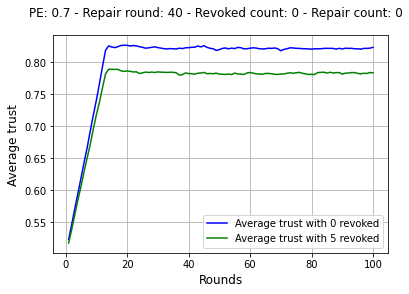

In [ ]:
mal_count = S * 10 // 100
_, total_average_without_revoked = run(mal_count, [], 0)
_, total_average_with_revoked = run(mal_count, [], 5)

indexes = np.arange(1, ITERATIONS_COUNT + 1);
plt.clf()
plt.plot(indexes, total_average_without_revoked, label=f'Average trust with 0 revoked', c='blue')
plt.plot(indexes, total_average_with_revoked, label=f'Average trust with 5 revoked', c='green')

plt.xlabel('Rounds', fontsize=12)
plt.ylabel("Average trust", fontsize=12)
plt.suptitle(f'PE: {PE} - Repair round: {REPAIR_ITERATION} - Revoked count: {REVOKED_NODES_COUNT} - Repair count: {REPAIRED_NODES_COUNT}')
plt.legend()
plt.grid()

In [ ]:
import cv2
from pathlib import Path

if GENERATE_PLOT_PNG:
  image_folder = PLOT_PNG_FOLDER
  video_name = 'repair.avi'
  video_path = os.path.join(Path(image_folder).parent, video_name)

  images = [
    img for img in os.listdir(image_folder) if img.endswith(".png")
    ]
  images.sort(key=lambda x: int(x[:-4]))
  frame = cv2.imread(os.path.join(image_folder, images[0]))
  height, width, layers = frame.shape

  video = cv2.VideoWriter(video_path, 0, 1, (width,height))

  for image in images:
      video.write(cv2.imread(os.path.join(image_folder, image)))

  cv2.destroyAllWindows()
  video.release()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


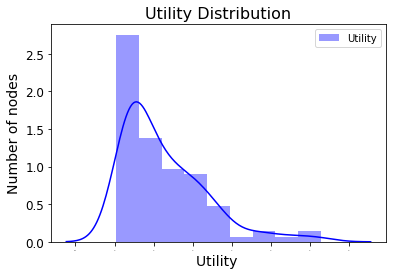

In [ ]:
import seaborn as sb # visualization 
# 3. Distribution plot

sb.distplot(data_frame['utility'], color = 'b', label = 'Utility')
plt.title('Utility Distribution', fontsize = 16)
plt.xlabel('Utility ', fontsize = 14)
plt.ylabel('Number of nodes', fontsize = 14)
plt.xticks(fontsize = 1)
plt.yticks(fontsize = 12)
plt.legend()